In [2]:
# Cleaned up version of MCMC model-fitting script
import numpy as np
import pymultinest as pmn
import matplotlib as plt

import os
import corner
import sys

from astropy.cosmology import w0waCDM, Flatw0waCDM
from exoticDE_fit.genclass_cosm import Cosmology

In [3]:
# Define cosmological parameters
Omega_m, Omega_merror = 0.3, 0.05

h0, w0, d_w0 = 70., 0.9, 0.1
ode0, wa = (1-Omega_m),(1.-w0)

# For use with the Cosmology class import
model_name, params = 'slowroll', [Omega_m, d_w0, h0]

# Using Cosmology class, Set n_params to 4, if Astropy, set to 5
parameters = 4

# add_ztf = True when using wfirst + ztf
add_ztf = True

In [4]:
# Define a cosmology:
# i.e. cosm_def = class_import(function_parameters) 

# cosm_def = w0waCDM(H0=h0, Om0=Omega_m, Ode0=ode0, w0=-w0, wa=-wa)# From astropy import
cosm_def = Cosmology(model_name,params) # From Cosmology import

In [5]:
### Define paths to data to use in the fit
### Need three arrays of: redshifts from data, generated distances, and errors

In [6]:
# ### WFIRST and ZTF data
# data_path = '/Users/markpoe/ZTF/exoticDE_fit/Ex_data/'

# # Paths to wfirst only data
# data_bins = data_path + 'wfirst_noLowz.dat' # wfirst only data
# cov_mat = np.loadtxt(data_path + 'syscov_WFIRST_nolowz.txt') # wfirst only cov matrix
# redshift,estat = np.loadtxt(data_bins, usecols=[1,5], unpack=True) # wfirst only reshift & errors

# if add_ztf:
#     # Paths to wfirst + ztf data
#     data_bins = data_path + 'comb_ztf_wfirst.dat' # ztf data
#     cov_mat = np.loadtxt(data_path + 'sys_cov_wfirst_ztf.dat') # ztf + wfirst cov matrix
#     redshift,estat = np.loadtxt(data_bins, unpack=True) #ztf + wfirst reshift & errors
#     print (len(redshift))
    
# cov_stat = np.diag(estat**2.)
# cov_temp = cov_mat + cov_stat
# inv_cov = np.linalg.inv(cov_temp)

# print (estat)

In [44]:
### JLA data
data_path = '../jla_data/'
data_bins = np.loadtxt(data_path + 'dist_binned.txt') 
cov_mat = np.loadtxt(data_path + 'covmat_binned.txt')

redshift = data_bins[:,0]
cov_mat *= 1e-6
inv_cov = np.linalg.inv(cov_mat)

In [45]:
### JLA + ZTF Data
ztf_data = np.loadtxt('/Users/markpoe/ZTF/exoticDE_fit/Ex_data/' + 'ztf_msip.dat') # ztf [z,sigma]
jla_err = np.loadtxt('diag_jla.dat', usecols = (0,1)) # JLA[z,sigma]

jla_ztf = np.concatenate((jla_err,ztf_data),axis=0) # JLA_Plus_ZTF [z,sigma]
# redshift = np.sort(jla_ztf[:,0]) # ZTF + JLA redshift

ztf_err = ztf_data[:,1] # ZTF errors only
jla_error = jla_err[:,1] # JLA errors only

In [46]:
### for running ztf in addition, within the ll function

estat2 = np.sort(ztf_err)
cov_stat = np.diag(estat2**2)
inv_cov2 = np.linalg.inv(cov_stat)
redshift2 = ztf_data[:,0]

gen_dist2 = cosm_def.luminosity_distance(redshift2)
cosm_dist2 = np.sort(gen_dist2)

# ### Temporary trial run
# om = np.linspace(0,1,40)
# chisq = np.sum((((om - Omega_m)**2)/i) for i in jla_ztf[:,0])
# print (len(chisq))
# print (chisq)
# np.sum(chisq)

In [47]:
# ### Perform linear algebra operations for the likelihood function and define errors 
# veestack = np.vstack([sorted(data_bins[:, 0]), (cosm_dist)]).T # Transpose using the generated cosm_dist array
# np.savetxt(data_path+'dist_binned_A.txt',veestack) # Save the generated data matrix
# gen_data_bins = np.loadtxt(data_path+'dist_binned_A.txt') # Load the generated data matrix

# cov_mat *= 1e-6
# Cinv = np.linalg.inv(cov_mat)

In [48]:
# Generate distances from the defined cosmological parameters and z values from given data set

# gen_dist = cosm_def.distmod(redshift) # From astropy import 
gen_dist = cosm_def.luminosity_distance(redshift) # From Cosmology import

print (gen_dist)
print (redshift)
print (len(redshift))
print (len(gen_dist))

[33.17409913 33.573095   33.91090999 34.20394221 34.58170305 35.00266825
 35.27344423 35.66292491 36.05610352 36.39134196 36.77361046 37.13959339
 37.48867199 37.84921124 38.23482097 38.60858631 38.9861078  39.3747952
 39.76396572 40.14706656 40.54919597 40.94859637 41.35414185 41.76932498
 42.18364667 42.60855324 43.03248216 43.46464676 43.89912873 44.33334724
 44.77051689]
[0.01  0.012 0.014 0.016 0.019 0.023 0.026 0.031 0.037 0.043 0.051 0.06
 0.07  0.082 0.097 0.114 0.134 0.158 0.186 0.218 0.257 0.302 0.355 0.418
 0.491 0.578 0.679 0.799 0.94  1.105 1.3  ]
31
31


In [32]:
# Sort distances and save to a text file
sort_dist = np.sort(gen_dist)
np.savetxt('cosm_dist.txt', sort_dist)

In [33]:
# Load distances from the text file
cosm_dist = np.loadtxt('cosm_dist.txt', usecols = 0)
print ( cosm_dist)

[33.17409913 33.573095   33.91090999 34.20394221 34.58170305 35.00266825
 35.27344423 35.66292491 36.05610352 36.39134196 36.77361046 37.13959339
 37.48867199 37.84921124 38.23482097 38.60858631 38.9861078  39.3747952
 39.76396572 40.14706656 40.54919597 40.94859637 41.35414185 41.76932498
 42.18364667 42.60855324 43.03248216 43.46464676 43.89912873 44.33334724
 44.77051689]


In [62]:
# Functions to calculate the log likelihood
def prior(cube, ndim, npar): 
    """
    Define the prior value for each parameter
    cube[0] = om
    cube[1] = w0
    cube[2] = wa
    cube[3] = H0
    cube[4] = M
    
    ndim, npar = ndim, npar in llhood
    """
    cube[0]  = cube[0]*1
    cube[1]  = cube[1]*4 - 2
    cube[2]  = cube[2]*6 - 3
    cube[3]  = cube[3]*50 + 50
    cube[4]  = cube[4]*0.00000000000001

def llhood(model_param, ndim, npar):
    """
    This is the function where we define the log likelihood 
    log(Lhood) = -0.5*chisquare
    
    Parameters
    ----------
    model_param : sequence
        sequence of model parameters (Om, w0, wa, H0, M)
        in a w0waCDM    
    ndim : integer
         length of model_params
    npar : integer
        The number of parameters 
    """
    # Define cosmological parameters to use with the prior function array
    om, W0, Wa, h_0, M = [model_param[i] for i in range(5)]
    
    # Define a cosmological model using prior values
    model = w0waCDM(H0=h_0, Om0=om, Ode0=1-om, w0=W0, wa=Wa)

    # Calculate distances using priors and z from given data
    dl_mpc = model.luminosity_distance(redshift).value
    mu_th = 5*np.log10(dl_mpc) + 25.
    
    # Calulate chi2 using (mu_th) - (mu_some_input_data) 
    dif_arr = mu_th - cosm_dist + M # Using generated data
    chisq = np.dot(dif_arr.T, np.dot(inv_cov, dif_arr)) + ((om - Omega_m)**2.)/((Omega_merror)**2.)
    
    # Return the log likelihood
    return -0.5*chisq

def prior_slowroll(cube, ndim, npar): 
    """ Slowroll Prior
    """
    cube[0]  = cube[0]*1.
    cube[1]  = cube[1]*2. - 1.
    cube[2]  = cube[2]*50. + 50.
    cube[3]  = cube[3]*0.00000000000001

def llhood_slowroll(model_param, ndim, npar):
    """Function similar to llhood that's built exclusively for the slowroll model
       Log=True in this case so we use .luminosity_distance(some_z) for the dist mod 
    """
    om, del_w, h_0, M = [model_param[i] for i in range(4)]
    wc = Cosmology(model_name,[om, del_w, h_0])
    
    mu_th = wc.luminosity_distance(redshift)
    diff_arr = mu_th - cosm_dist + M
    
    mu_th2 = wc.luminosity_distance(redshift2)
    diff_arr2 = mu_th2 - cosm_dist2 + M
    
    # options for the extra term 
#     np.sum(np.sum((((om - Omega_merror)**2)/i**2) for i in jla_ztf[:,0]))
#     np.sum((((om - Omega_merror)**2)/i**2) for i in ztf_err)

    # jla + ztf run separately
    chisq = (np.dot(diff_arr.T, np.dot(inv_cov, diff_arr)) 
    + np.dot(diff_arr2.T, np.dot(inv_cov2, diff_arr2)) 
    + ((om - Omega_m)**2.)/((Omega_merror)**2.))
    
#     chisq = np.dot(diff_arr.T, np.dot(inv_cov, diff_arr)) + ((om - Omega_m)**2.)/((Omega_merror)**2.)
    return -0.5*chisq

In [56]:
# Dependency of live points on the number of parameters
if parameters==5:
    log_llhood, prior_func, livepoints = llhood, prior, 700
    print ('params = 5')
elif parameters==4:
    log_llhood, prior_func, livepoints = llhood_slowroll, prior_slowroll, 400
    print ('params = 4')
else:
    print ('How many parameters are set for the llhood function')

params = 4


In [57]:
Omega_merror = .01

In [82]:
# Name a directory using the current model to be run with this script

current_model = 'jla_ztf_crazy_test_run15'

# In order to calculate the delta log evidence as in the Jeffery's scale, 
#   define an existing chain directory for a previously run model

comparison_model = 'JLA_sr_sig01' 

# Creates the directory name and path for current model
chains_directory = '/Users/markpoe/ZTF/lowzSN/notebooks/chains/' # General chains directory 
chain_dir = (chains_directory + current_model + '/') # Specific chain directory

# Create the necessary directory to store chains
if not os.path.exists(chain_dir):
    os.makedirs(chain_dir)

In [59]:
# Create chains and statistical data using pymultinest 'run.py'; when npar < 5, can set n_live_points=400
pmn.run(log_llhood, prior_func, n_dims=parameters, verbose=True, n_live_points=livepoints, resume=False, outputfiles_basename=chain_dir)


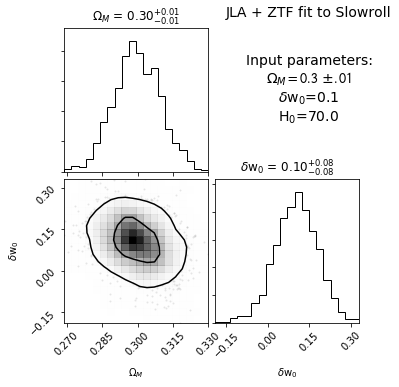

In [71]:
# Fetch data and create contour plots for comparison
data = np.loadtxt(chain_dir+'post_equal_weights.dat')
figure = corner.corner(data[:,[0,1]], smooth=1, levels=(1 - np.exp(-0.5),1 - np.exp(-2.)), 
                       labels=[r'$\Omega_M$', r'$\delta$w$_0$', r'w$_a$', 'h0', 'M', 'llhood'], verbose=True,show_titles=True)

#  r'w$_0$w$_a$CDM'
figure.suptitle( 'JLA + ZTF fit to Slowroll'+ '\n' + '\n\nInput parameters:\n'
                + r'$\Omega_{M}$' + r'$\mathcal{=0.3}$ '+ r'$\pm$'+r'$\mathcal{.01}$'+'\n' 
                + r'$\delta$w$_0$=0.1'+'\nH$_0$=70.0'
                ,x=0.8,fontsize=14) 
figure.savefig('./plots/contours/'+current_model)


# figure = corner.corner(data[:,[0,1,2]], smooth=1.5, levels=(1 - np.exp(-0.5),1 - np.exp(-2.)), 
#                        labels=['om', 'w0', 'wa', 'h0', 'M', 'llhood'], show_titles=True, 
#                       truths=[.3,.1,70.,None,None], color = 'k', truth_color = 'r',bins = 30,
#                        quantiles=[.7,.5,.3], use_math_text=True, plot_contours=False)   

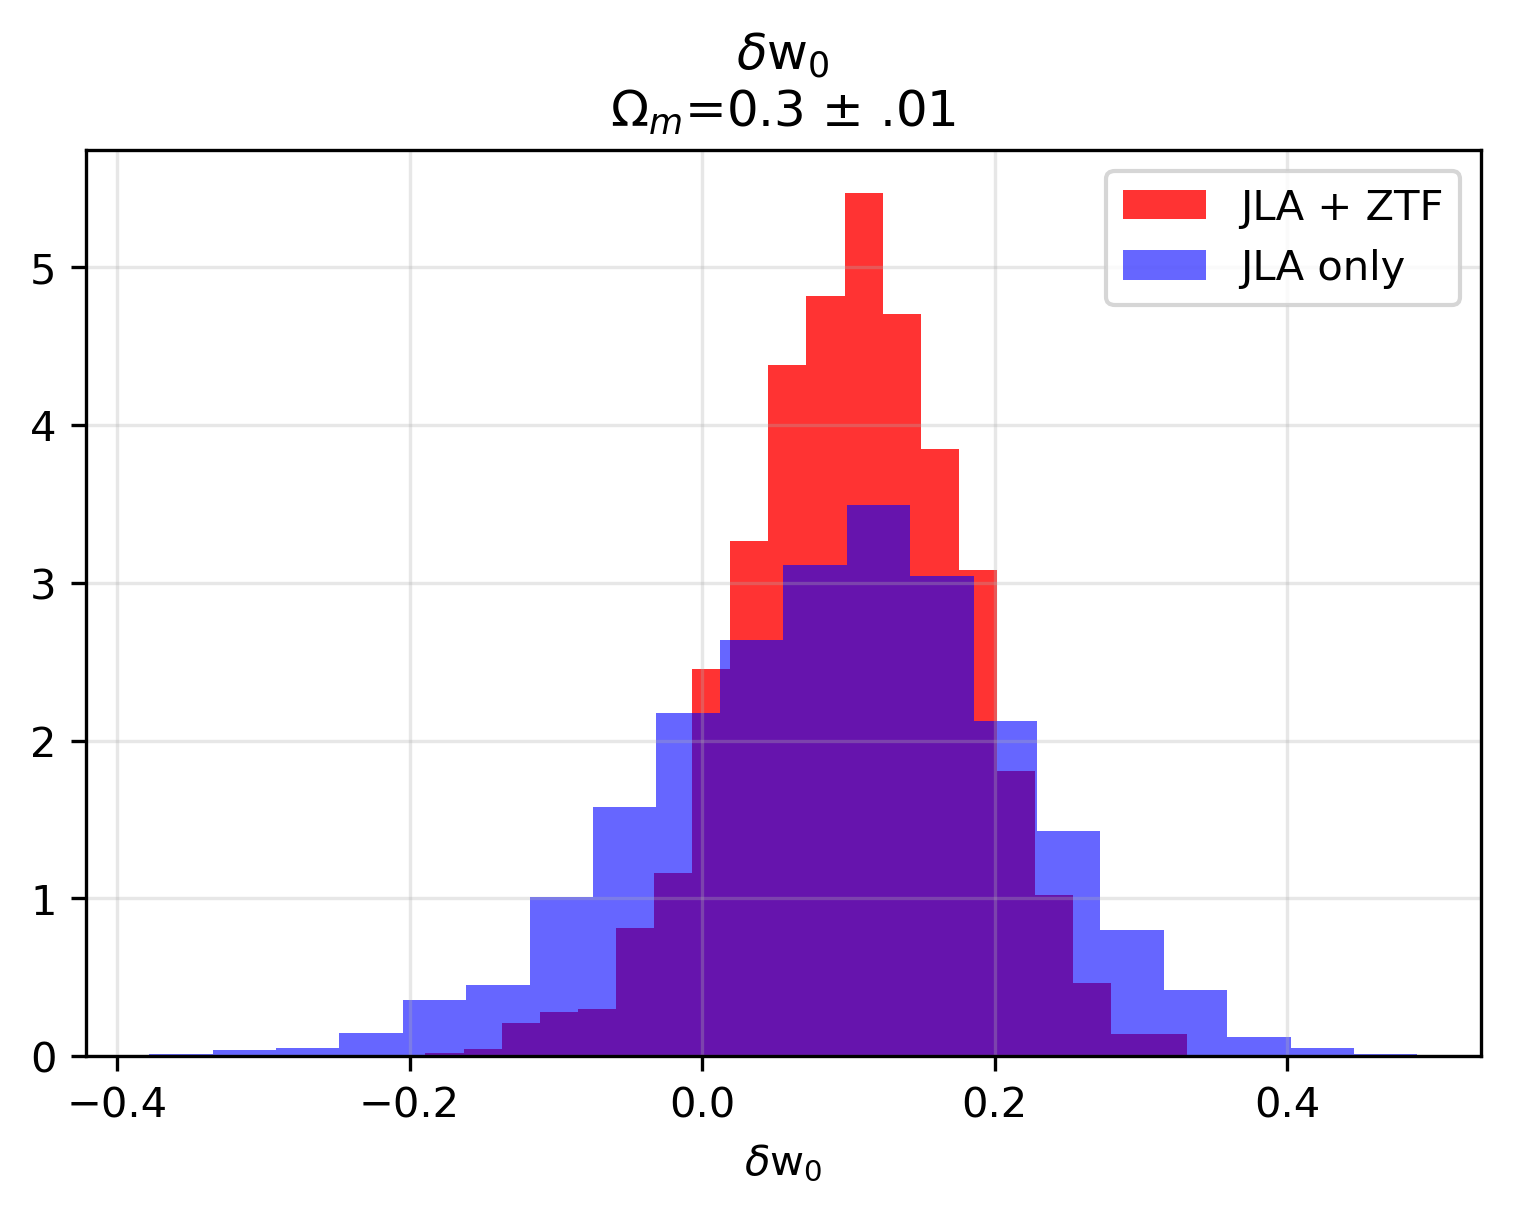

In [88]:
import matplotlib.pyplot as plt
chain_dir2 = (chains_directory+comparison_model+'/')
data1 = np.loadtxt(chain_dir+'post_equal_weights.dat')
data2 = np.loadtxt(chain_dir2 + 'post_equal_weights.dat')

bins=20
plt.grid(True, alpha=.3)
plt.hist(data1[:,1],bins,color='r',alpha=.8,label='JLA + ZTF',histtype='stepfilled',density=True)
plt.hist(data2[:,1],bins,color='b',alpha=.6,label='JLA only',histtype='stepfilled',density=True)


plt.xlabel(r'$\delta$w$_0$')
plt.title(r'$\delta$w$_0$'+'\n$'+'\Omega_m$=0.3 $\pm$ .01')



plt.legend()
plt.show()

import matplotlib as mpl
plt.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300

In [113]:
print (len(data1[:,1]))


y = np.float(np.linspace(0,1,50))
# corner.hist2d(data2[:,1],y,bins)
figg = corner.hist2d(data1[:,1],y, bins=50)

1658


TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
# !cat '/Users/markpoe/ZTF/lowzSN/notebooks/chains/model_fitting_trial_run4/stats.dat'
filename=(chain_dir+'stats.dat')
temp=[]
tempp=[]
with open(filename,'r') as f:
    for line in f:
#         print (line)
        temp.append(line)
print ('w0 Mean and sigma','\n',temp[5],'wa Mean and sigma','\n',temp[6])

In [ ]:
### Access log evidence and calculate delta log evidence for two models

# Define variables for use in a loop
stat = '/stats.dat'
Model_1 = chains_directory + current_model +  stat
Model_2 = chains_directory + comparison_model +  stat

# Build array of log evs for two models
ev = []
models = [Model_1,Model_2]
for x in models:
    with open(x, "r") as f:
        for line in f:
            if "Nested Sampling Global Log-Evidence" in line:
                ev.append(line)
    f.close()
print (ev)

# Extract the evidences from the above array and convert to float
z = []
for x in ev:
    y = x.split(':')
    t = y[1].split('+/-')
    z.append(t[0])
ev1,ev2 = float(z[0]), float(z[1])
# print ('\n','Log evs as floats','\n',ev1,ev2)

# Calculate and print delta of the log evidences
delta_lnE = np.abs(ev1 - ev2)
print ('\n','Delta Log Evidence of the two models','\n',delta_lnE)

In [ ]:
# Print evidences and the abs value of delta evidences
e1 = np.exp(ev1)
e2 = np.exp(ev2)
print (e1, 'Evidence for current model')
print (e2, 'Evidence for comparison model')
delta_evidence = np.abs(e1 - e2)
print ('\n','Delta evidence','\n', delta_evidence)

# Print Bayes factor ev1/ev2
# Bayes_factor = np.divide(np.exp(ev1),np.exp(ev2))
Bayes_factor = np.divide(np.exp(ev2),np.exp(ev1))

# Print log of the Bayes Factor, should be same as delta log evs
log_bayes_factor = np.abs(np.log(Bayes_factor))
print ('\n','Log Bayes Factor (Delta Log evs)','\n',log_bayes_factor)

# If the log bayes is negative, can use this to find bayes factor
# Bayes_factor = np.exp(np.abs(log_bayes_factor))
print ('\n','Bayes Factor','\n',Bayes_factor)

# Not sure if we need to use absolute values on the Bayes factors here
# Double check with someone who knows about this

In [ ]:
# ### Define here:
# current_model = 'model_fitting_trial_run3'
# comparison_model = 'model_fitting_trial_run2' 
# data_path = '../jla_data/'
# bin_file = 'dist_binned.txt'
# cov_mat_file = 'covmat_binned.txt'
# # cosm_def = w0waCDM(H0=70., Om0=0.3, Ode0=.7, w0=-.9, wa=-.1)
# cosm_def = Cosmology('slowroll',[0.3,0.1,70.])